In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

## specify # of nodes
Nin: int = 2
Ninter: int = 0
Nout: int = 1

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
# R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
R_update: str = 'deltaR_propto_Power'
# R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])
R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]

# length of training dataset
iterations = 1600  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 30

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
stay_sample: int = 2  # how many loop iterations to stay under the same sampled p

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

alpha_vec [0.5]
input M mismatches output and input


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1]
inter_nodes_arr  []
output_nodes_arr  [2]
ground_nodes_arr  [3]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs.Nin, Variabs.Nout, Ninter)
else:
    State = Network_State(Variabs.Nin, Variabs.Nout)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

R_vec_i has wrong size, initializing all ones


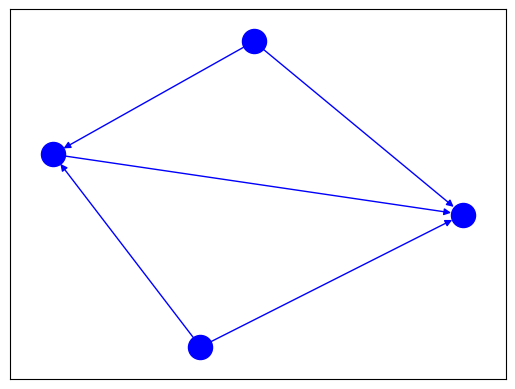

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=False)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag:
        k = (i//stay_sample)*2 + i%2
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    State.draw_p_in_and_desired(Variabs, k)
    
    # measure
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
    # if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        State.update_output_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t):
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
output measured= [0.88350295]
i 1
k 1
input_drawn [1.46398788 1.19731697]
desired output= [0.45906158]
output measured= [0.88710162]
loss= [[-0.42804004]
 [-0.39085519]]
time= 1
input_dual_nxt= [ 0.01329187 -0.01309114]
output_dual_nxt [-6.69079479e-05]
i 2
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034]
output measured= [0.20800847]
i 3
k 3
input_drawn [0.11616722 1.73235229]
desired output= [0.36389554]
output measured= [0.61626603]
loss= [[-0.25237049]
 [-0.09880507]]
time= 2
input_dual_nxt= [-0.01503943  0.10905934]
output_dual_nxt [-0.03134712]
i 4
k 4
input_drawn [1.20223002 1.41614516]
desired output= [0.46356353]
output measured= [0.86896044]
i 5
k 5
input_drawn [0.04116899 1.9398197 ]
desired output= [0.39413929]
output measured= [0.65197566]
loss= [[-0.25783637]
 [-0.4053969 ]]
time= 3
input_dual_nxt= [ 0.08566339 -0.03863685]
output_dual_nxt [-0.01600919]
i 6
k 6
input_drawn [1.66488

output measured= [0.48921559]
i 205
k 205
input_drawn [0.63862728 1.90012393]
desired output= [0.47581888]
output measured= [0.66674814]
loss= [[-0.19092926]
 [-0.18108633]]
time= 103
input_dual_nxt= [-0.00576863  0.00845287]
output_dual_nxt [-0.00087372]
i 206
k 206
input_drawn [1.90121429 1.14687578]
desired output= [0.5145573]
output measured= [0.77080185]
i 207
k 207
input_drawn [1.26367442 0.89689104]
desired output= [0.36892937]
output measured= [0.54856227]
loss= [[-0.1796329 ]
 [-0.25624455]]
time= 104
input_dual_nxt= [0.02442149 0.00957587]
output_dual_nxt [-0.00851307]
i 208
k 208
input_drawn [0.58642154 0.65732909]
desired output= [0.21942905]
output measured= [0.31942881]
i 209
k 209
input_drawn [1.34503691 1.50474906]
desired output= [0.50270535]
output measured= [0.73186596]
loss= [[-0.22916062]
 [-0.09999976]]
time= 105
input_dual_nxt= [0.04899171 0.05472675]
output_dual_nxt [-0.02663537]
i 210
k 210
input_drawn [1.58315809 1.57923629]
desired output= [0.55332097]
output

i 418
k 418
input_drawn [1.8296918 0.7247878]
desired output= [0.41941133]
output measured= [0.57508761]
i 419
k 419
input_drawn [1.1611767  1.26452858]
desired output= [0.42708222]
output measured= [0.56104409]
loss= [[-0.13396187]
 [-0.15567628]]
time= 210
input_dual_nxt= [ 0.0072582  -0.00586007]
output_dual_nxt [-0.00015247]
i 420
k 420
input_drawn [0.02618891 1.32707474]
desired output= [0.26934329]
output measured= [0.3291243]
i 421
k 421
input_drawn [0.35607193 1.92214063]
desired output= [0.43783892]
output measured= [0.54598536]
loss= [[-0.10814644]
 [-0.05978101]]
time= 211
input_dual_nxt= [0.00797747 0.01439031]
output_dual_nxt [-0.00524429]
i 422
k 422
input_drawn [0.29732546 0.82924825]
desired output= [0.21044847]
output measured= [0.26682199]
i 423
k 423
input_drawn [0.17069934 1.9937485 ]
desired output= [0.4243546]
output measured= [0.52301987]
loss= [[-0.09866527]
 [-0.05637352]]
time= 212
input_dual_nxt= [-0.00267762  0.02462438]
output_dual_nxt [-0.00541753]
i 424
k

output measured= [0.05074228]
i 645
k 645
input_drawn [0.79384655 0.26543151]
desired output= [0.17216328]
output measured= [0.22845705]
loss= [[-0.05629376]
 [-0.00934995]]
time= 323
input_dual_nxt= [0.01707441 0.00254141]
output_dual_nxt [-0.0041713]
i 646
k 646
input_drawn [1.1350817  1.37892994]
desired output= [0.44604824]
output measured= [0.56088608]
i 647
k 647
input_drawn [1.6011734  0.40030049]
desired output= [0.32023611]
output measured= [0.42910456]
loss= [[-0.10886845]
 [-0.11483783]]
time= 324
input_dual_nxt= [-0.00139114  0.00292091]
output_dual_nxt [-0.00039333]
i 648
k 648
input_drawn [0.33496516 0.20913568]
desired output= [0.09207191]
output measured= [0.11915913]
i 649
k 649
input_drawn [1.2728605  1.41295145]
desired output= [0.47351937]
output measured= [0.59770999]
loss= [[-0.12419063]
 [-0.02708722]]
time= 325
input_dual_nxt= [0.04553642 0.05844731]
output_dual_nxt [-0.02323446]
i 650
k 650
input_drawn [0.06317229 1.87242449]
desired output= [0.38396074]
output

output measured= [0.42410718]
i 891
k 891
input_drawn [0.92295493 1.27440295]
desired output= [0.39332383]
output measured= [0.47349909]
loss= [[-0.08017526]
 [-0.05187447]]
time= 446
input_dual_nxt= [ 0.01197268 -0.00748727]
output_dual_nxt [-0.00069892]
i 892
k 892
input_drawn [1.31870784 1.79023548]
desired output= [0.55585327]
output measured= [0.66959009]
i 893
k 893
input_drawn [1.27333936 1.22786717]
desired output= [0.43657434]
output measured= [0.53306185]
loss= [[-0.09648751]
 [-0.11373682]]
time= 447
input_dual_nxt= [0.00039129 0.00485023]
output_dual_nxt [-0.00117751]
i 894
k 894
input_drawn [0.13330408 1.03681604]
desired output= [0.22735882]
output measured= [0.26164649]
i 895
k 895
input_drawn [0.300338   1.47486754]
desired output= [0.34002421]
output measured= [0.39434449]
loss= [[-0.05432028]
 [-0.03428767]]
time= 448
input_dual_nxt= [0.00167306 0.00438766]
output_dual_nxt [-0.00132914]
i 896
k 896
input_drawn [1.02444384 1.36045556]
desired output= [0.42575769]
outpu

i 1138
k 1138
input_drawn [1.48718783 1.01253212]
desired output= [0.4255846]
output measured= [0.51434083]
i 1139
k 1139
input_drawn [1.26820806 0.14186443]
desired output= [0.2186041]
output measured= [0.27832967]
loss= [[-0.05972557]
 [-0.08875623]]
time= 570
input_dual_nxt= [0.00317856 0.01263803]
output_dual_nxt [-0.00342578]
i 1140
k 1140
input_drawn [0.50878316 0.72370619]
desired output= [0.22105871]
output measured= [0.25975985]
i 1141
k 1141
input_drawn [0.94498671 0.09129749]
desired output= [0.1600075]
output measured= [0.20419046]
loss= [[-0.04418296]
 [-0.03870114]]
time= 571
input_dual_nxt= [ 0.00119559 -0.00173337]
output_dual_nxt [0.00015231]
i 1142
k 1142
input_drawn [0.2800482  0.55362862]
desired output= [0.15273295]
output measured= [0.17746813]
i 1143
k 1143
input_drawn [1.94306538 0.66269401]
desired output= [0.42399861]
output measured= [0.52534742]
loss= [[-0.10134881]
 [-0.02473518]]
time= 572
input_dual_nxt= [0.06370489 0.00417795]
output_dual_nxt [-0.0133261

i 1382
k 1382
input_drawn [0.2685497  1.91586824]
desired output= [0.4234561]
output measured= [0.47114665]
i 1383
k 1383
input_drawn [1.05931945 0.48378659]
desired output= [0.25565523]
output measured= [0.30844643]
loss= [[-0.05279119]
 [-0.04769055]]
time= 692
input_dual_nxt= [ 0.00201672 -0.00365227]
output_dual_nxt [0.00041494]
i 1384
k 1384
input_drawn [1.00120714 1.35924067]
desired output= [0.4220292]
output measured= [0.4891818]
i 1385
k 1385
input_drawn [0.15247844 0.54940763]
desired output= [0.13275329]
output measured= [0.14953125]
loss= [[-0.01677796]
 [-0.06715259]]
time= 693
input_dual_nxt= [0.0213772  0.02039752]
output_dual_nxt [-0.00855489]
i 1386
k 1386
input_drawn [1.61393098 0.91932974]
desired output= [0.4259556]
output measured= [0.50978542]
i 1387
k 1387
input_drawn [1.09315428 0.865632  ]
desired output= [0.33709954]
output measured= [0.39851736]
loss= [[-0.06141781]
 [-0.08382982]]
time= 694
input_dual_nxt= [0.00583583 0.00060174]
output_dual_nxt [-0.00124687

## Plots

### importants + network

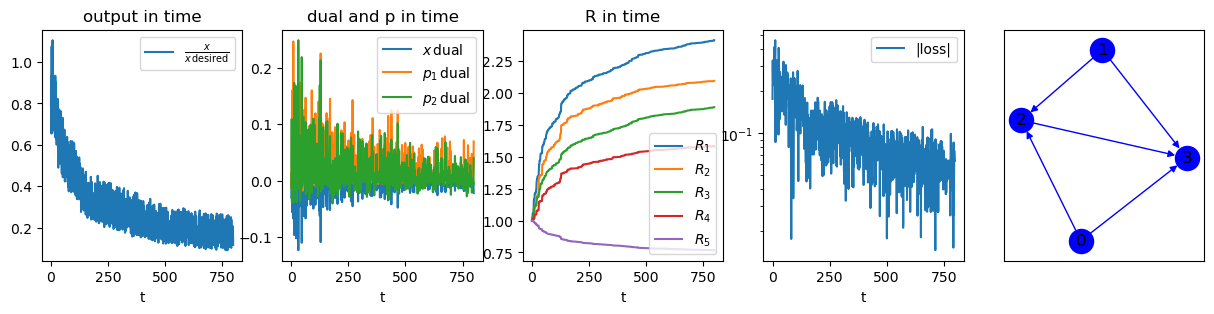

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

### accuracy

In [13]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(Variabs, State)
else:
    pass

## Save sizes to file

In [14]:
# R_propto_deltap = State.R_in_t
# deltaR_propto_deltap = State.R_in_t
# deltaR_propto_Q = State.R_in_t
# deltaR_propto_Power = State.R_in_t

# loss_R_propto_deltap = State.loss_in_t
# loss_deltaR_propto_deltap = State.loss_in_t
# loss_propto_Q = State.loss_in_t
# loss_propto_Power = State.loss_in_t

In [15]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)

In [27]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [52]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

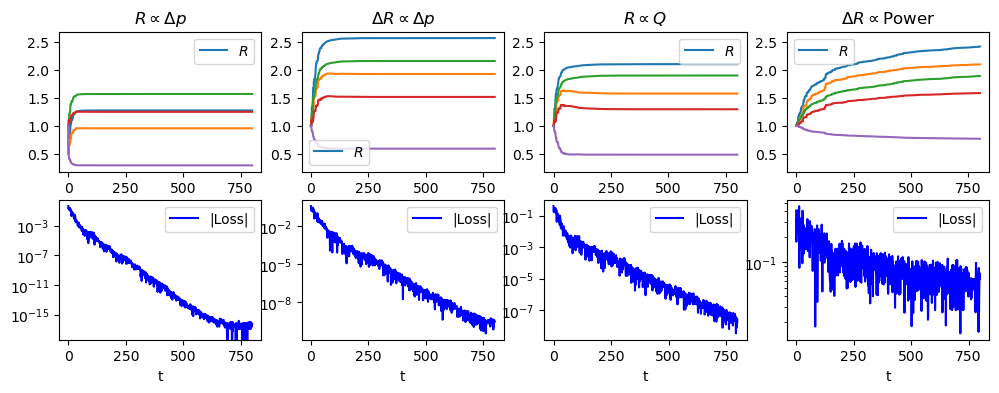

In [51]:
plot_functions.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [17]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [18]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [53]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

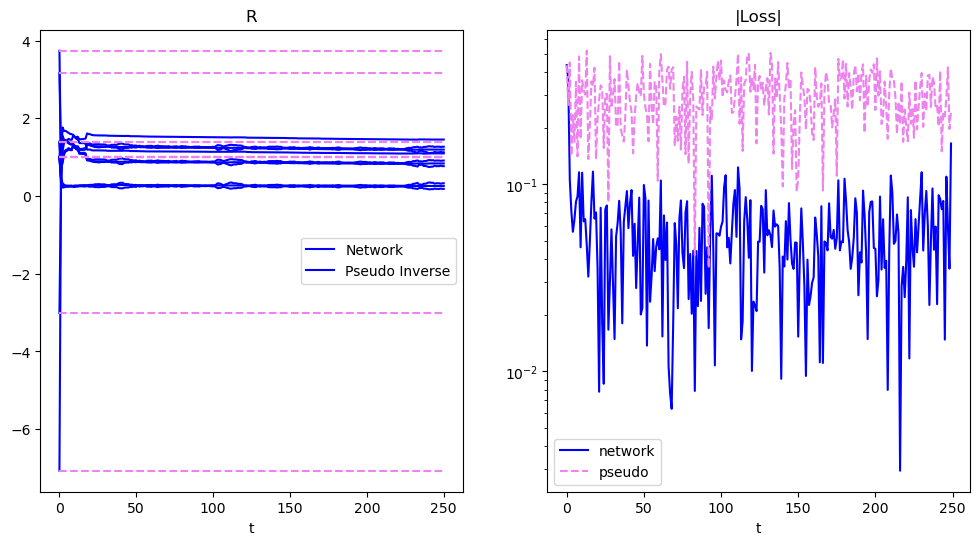

In [54]:
plot_functions.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

## Statistics

### Error

In [22]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.1613963393704857


### Accuracy

In [24]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    print('net prediction', np.sum((State.targets_mat - State.output)**2, axis=1))
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
output measured= [0.5552115]


NameError: name 'targets_mat' is not defined

In [ ]:
Variabs.targets

In [ ]:
np.mean(accuracy)

In [ ]:
targets_mat

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)

In [ ]:
measure_accuracy_every=30

30 // measure_accuracy_every

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) = axs

titles = [
        r'$R \propto \Delta p$',
        r'$\Delta R \propto \Delta p$',
        r'$R \propto Q$',
        r'$\Delta R \propto \text{Power}$'
    ]

# Data for the plots
resistance_data = [array([0.1, 1]), array([0.1, 1]), array([0.1, 1]), array([0.1, 1])]

# Plot resistance data (top row)

zpp = zip([ax1, ax2, ax3, ax4], resistance_data, titles)

In [ ]:
zpp